In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import IntSlider, Output
from itertools import product
from scipy.signal import find_peaks
import math
from mpl_toolkits.mplot3d import Axes3D

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import dataset_path_qt

In [2]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)
save_fig=False
plot_fig=True 

In [3]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [4]:
tdc, pulse_mode, flightPathLength_d, t0_d, max_tof = wd.dataset_tdc_selection()
display(tdc, pulse_mode, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [8]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()
# variables.path = os.path.join(p, 'tests//data')
variables.result_path = os.path.dirname(dataset_main_path) + '/tof_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


In [6]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),mc (Da),x (mm),y (mm),pulse_pi,ion_pp)
0,5249.145020,5249.145020,36627.0,630.126756,None,-11.015510,-15.058776,0.0,1.0
1,5249.145020,5249.145020,37581.0,627.623586,None,-10.251429,-13.116735,954.0,1.0
2,5249.145020,5249.145020,37688.0,627.829326,None,-10.601633,-13.848980,107.0,1.0
3,5249.145020,5249.145020,37747.0,640.310886,None,0.955102,25.819592,59.0,1.0
4,5249.145020,5249.145020,37900.0,625.792500,None,-2.515102,7.067755,153.0,1.0
...,...,...,...,...,...,...,...,...,...
1912930,5710.761719,5710.761719,40624.0,460.987902,None,33.269388,16.459592,236.0,1.0
1912931,5710.761719,5710.761719,40985.0,606.830130,None,3.470204,14.613061,361.0,1.0
1912932,5710.761719,5710.761719,41042.0,606.590100,None,5.571429,9.964898,57.0,1.0
1912933,5710.761719,5710.761719,41115.0,599.917266,None,3.088163,-8.850612,73.0,1.0


In [7]:
# t0
# dld_t = data['t (ns)'].to_numpy()
# dld_t = dld_t - t0

In [8]:
# Remove negative TOF
# threshold = 0
# dld_t_mask = data['t (ns)'].to_numpy()
# dld_t_mask = (dld_t <= threshold)
# data.drop(np.where(dld_t_mask)[0], inplace=True)
# data.reset_index(inplace=True, drop=True)


<IPython.core.display.Javascript object>


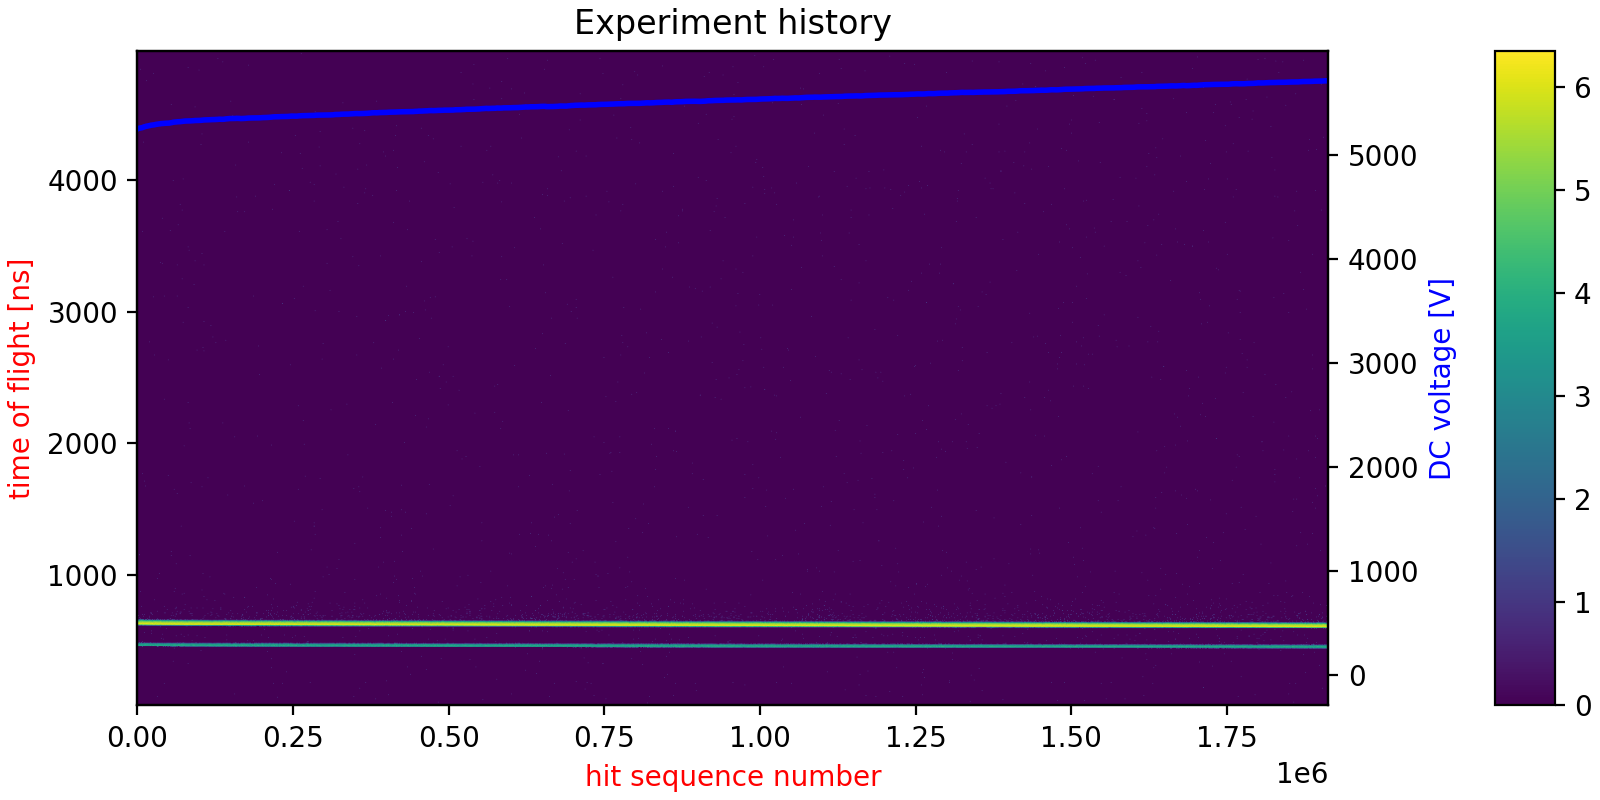

In [9]:
data_loadcrop.plot_crop_experimetn_history(data, save_name=variables.result_path + '//ex_hist_' + dataset_name)


In [10]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x (mm)'].to_numpy()
dld_y = data['y (mm)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

<IPython.core.display.Javascript object>


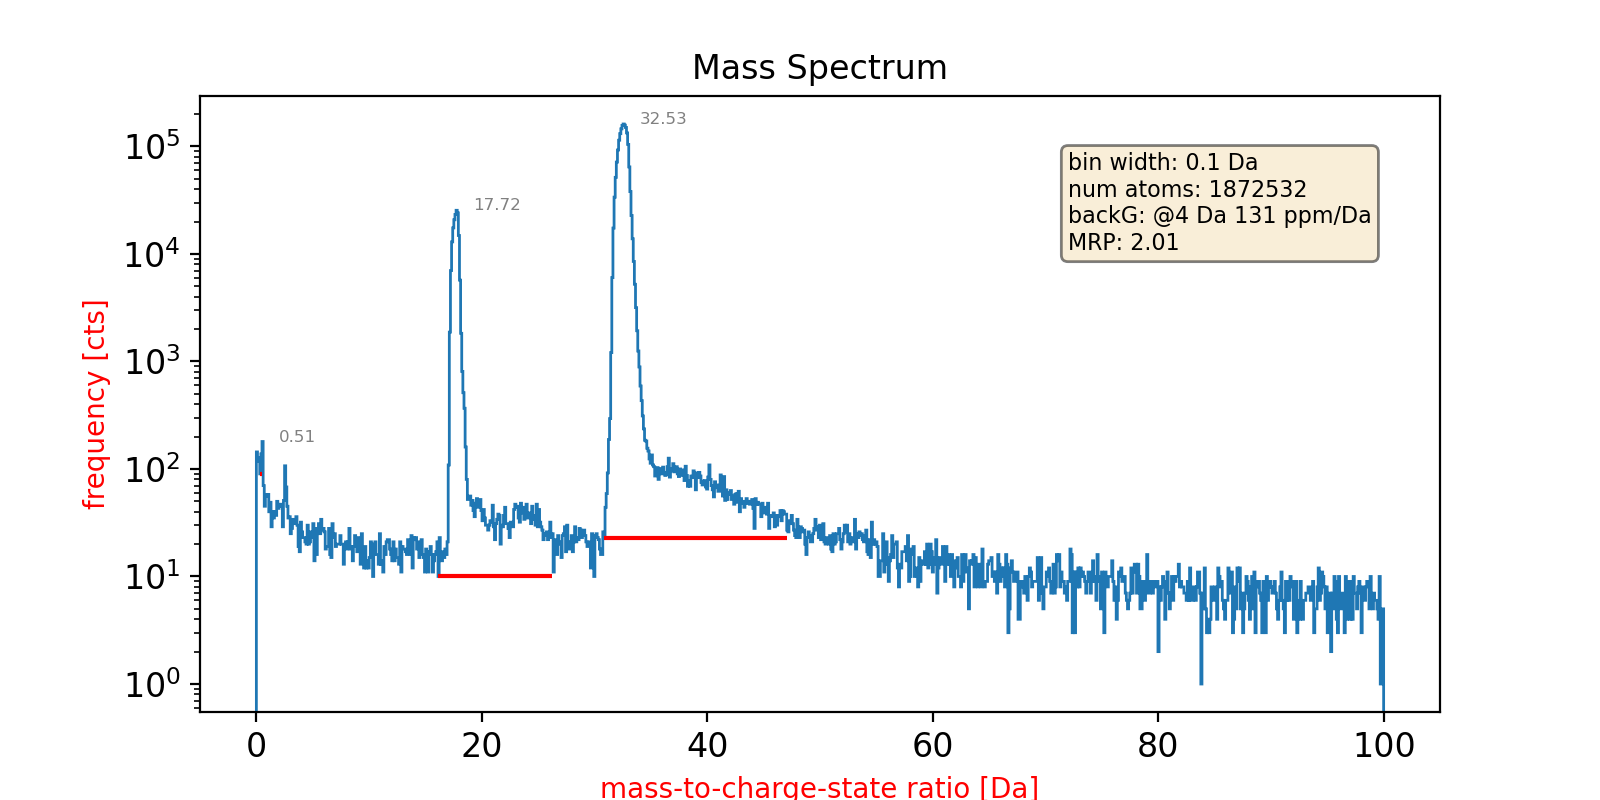

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 2.0066672880086434
Peaks  0 is at location and height: (0.51, 180.00) peak window sides (99.99%) are: (0.31, 0.51)
Peaks  1 is at location and height: (17.72, 25457.00) peak window sides (99.99%) are: (16.12, 26.22)
Peaks  2 is at location and height: (32.53, 161594.00) peak window sides (99.99%) are: (30.83, 47.04)


In [57]:
percent_mrp = 50
lim = 100
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode=pulse_mode_ini)
peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc_seb_ini[mc_seb_ini < lim], 0.1, prominence=50, distance=100, h_line=True, text_loc='right', percent=percent_mrp, plot=True, fig_name=figname)
index_max_ini = np.argmax(peaks_y_ini)
mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_ini)):
    print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [29]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=500, description='peak distance:')
lim_tof=widgets.IntText(value=1500, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')

def hist_plot(figname, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        selector = 'rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_tof_p], bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p, selector=selector, plot=plot, label='tof', fig_name=figname)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
            print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [30]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, figname=figname):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value
        if plot_p:
            clear_output(True)

        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p)


In [31]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='save fig:'
)
def vol_correction(dld_highVoltage, figname):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        if plot_p:
            clear_output(True)
        calibration.voltage_corr_main(dld_highVoltage, sample_size=sample_size_p, calibration_mode='tof',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p)


Output()

<IPython.core.display.Javascript object>


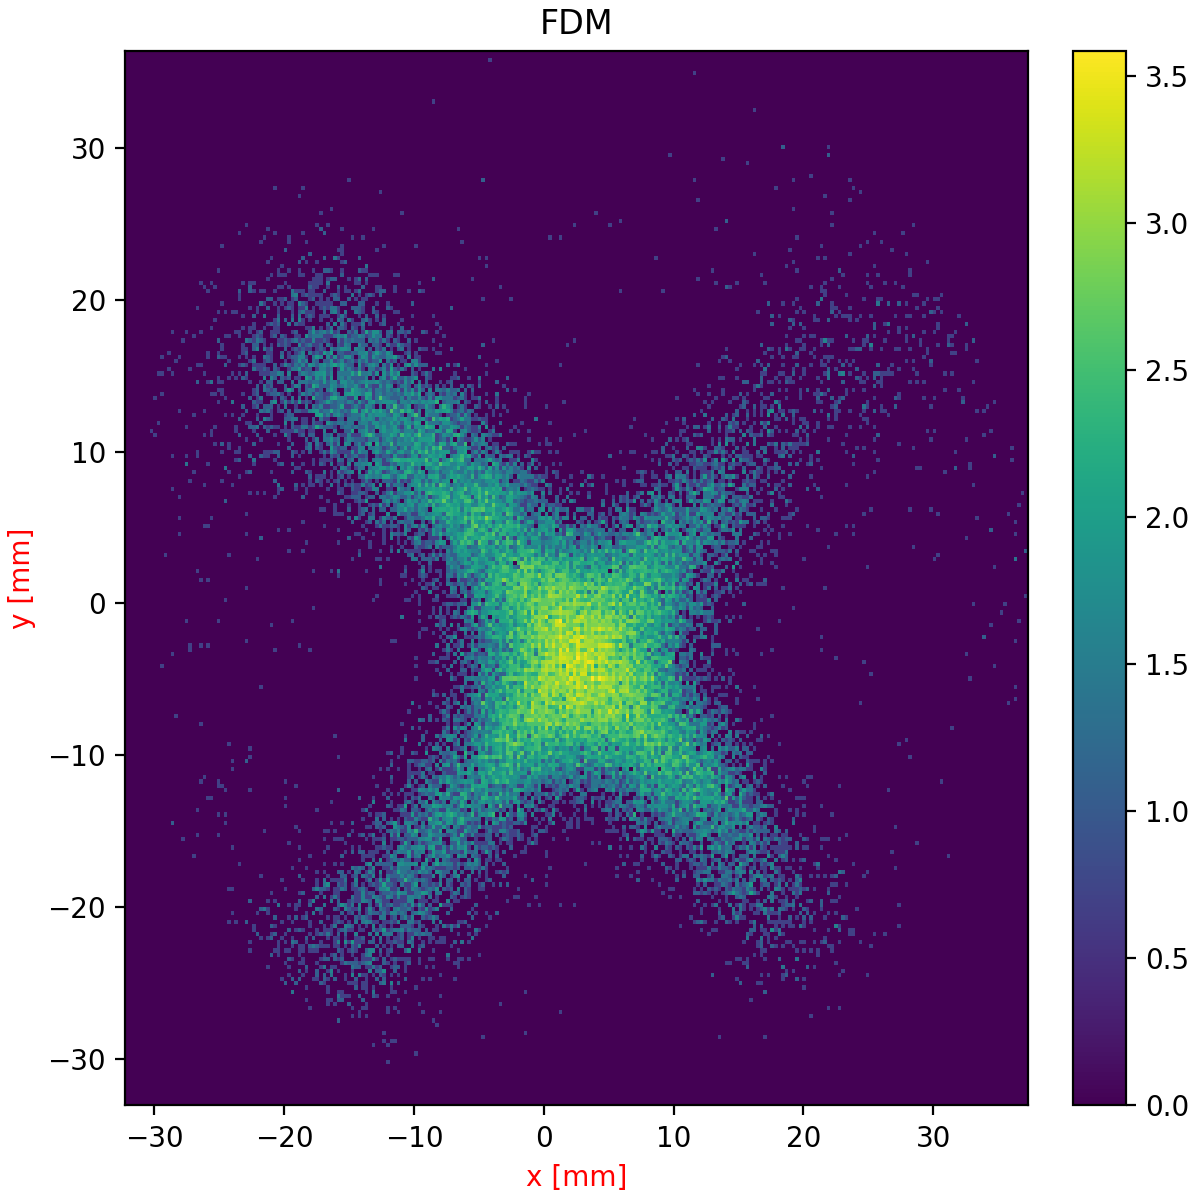

[256, 256]


In [32]:
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_button = widgets.Button(
    description='reset correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')
    
@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, save=True):
    mask_temporal = np.logical_and((variables.dld_t_calib > variables.selected_x1),
                                   (variables.dld_t_calib < variables.selected_x2))
    x = dld_x[mask_temporal]
    y = dld_y[mask_temporal]
    bin_fdm_p = bin_fdm.value
    bins = [bin_fdm_p, bin_fdm_p]

    calibration.plot_FDM(x, y, save, bins)
    
@reset_button.on_click
def reset_on_click(b, figname=figname, plot=True):
    variables.dld_t_calib = np.copy(dld_t)
    
@bowl_button.on_click
def bowl_on_click(b, dld_x=dld_x, dld_y=dld_y, dld_highVoltage=dld_highVoltage, figname=figname):
    bowl_correction(dld_x, dld_y, dld_highVoltage, figname)  

@vol_button.on_click
def vol_on_click(b, dld_highVoltage=dld_highVoltage, figname=figname):
    vol_correction(dld_highVoltage, figname)
    


tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, plot_b, save_b]), bowl_button])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, plot_v, save_v]), vol_button])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, reset_button])]))
out = Output()
display(out)

In [37]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_dld_t):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.dld_t_calib[variables.dld_t_calib < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='tof', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
                   print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [38]:

interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_dld_t=widgets.IntText(value=1500)
               ,percent=widgets.IntText(value=50), selector=fixed('peak'), plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [39]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), element[2],)
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

listMaterial = buttonAdd.on_click(wd.onClickAdd)
buttonDelete.on_click(wd.onClickDelete)
buttonReset.on_click(wd.onClickReset)

Dropdown(description='Elements', options=(('H (1) (99.98)', 1.01), ('H (2) (0.01)', 2.01), ('He (3) (0.00)', 3…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

In [44]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(variables.peak[variables.peaks_idx[i]])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: [176.44991695 462.47767683 626.80206545]
highest peak in the ideal mc histogram: [ 1.01 13.49 26.98]


In [45]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


mc_p_1 = parametric(variables.dld_t_calib, *fitresult)

C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [50]:
print('The t0 is:', fitresult[0], 'ns')

The t0 is: 64.01643733262624 ns


<IPython.core.display.Javascript object>


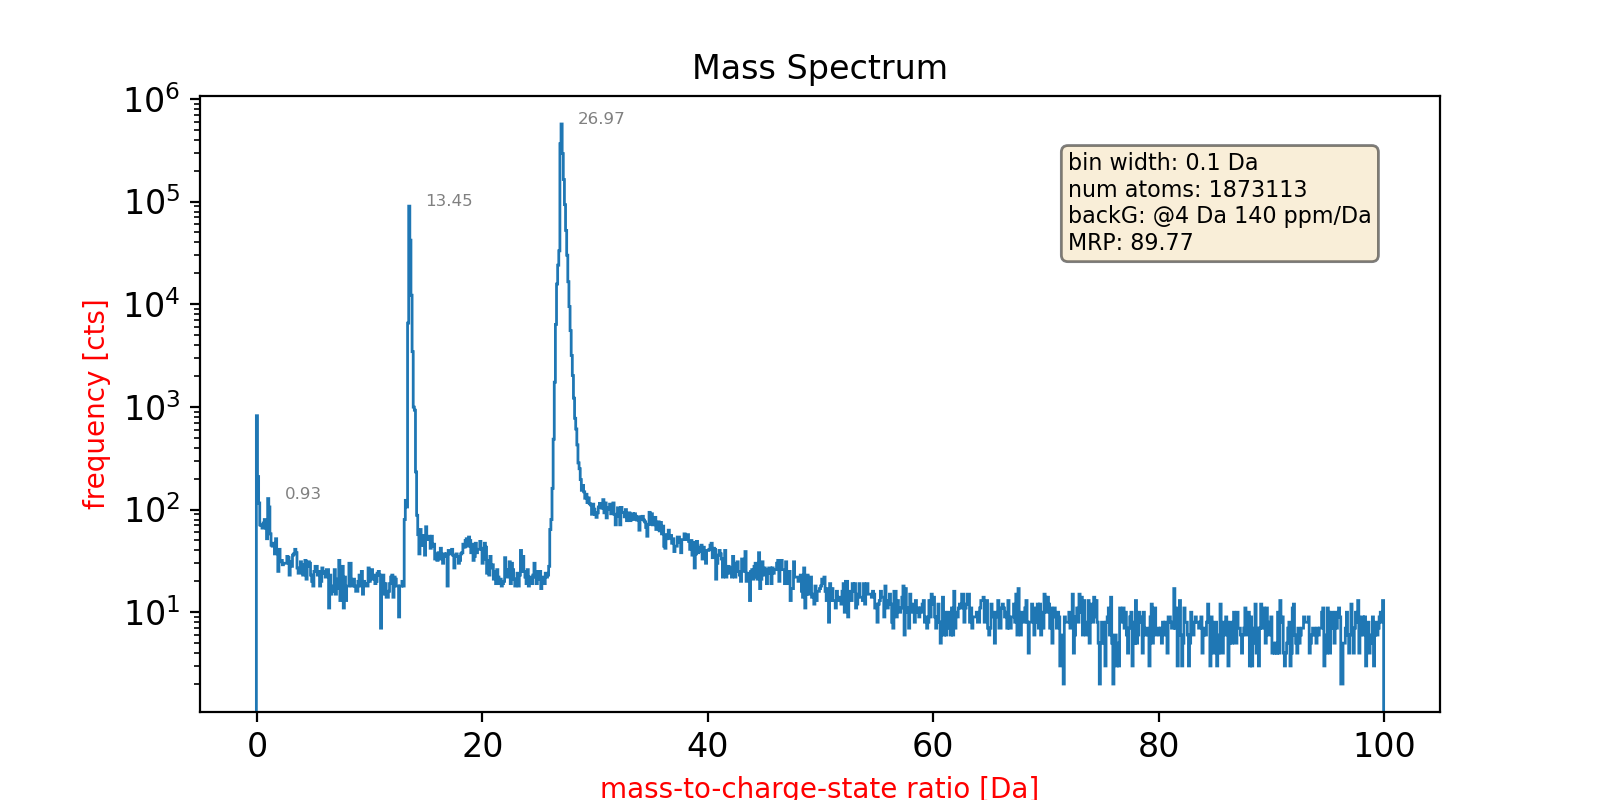

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): 26.95414996885353
Peaks  0 is at location and height: (0.51, 180.00) peak window sides (50.00%) are: (0.31, 0.51)
Peaks  1 is at location and height: (17.72, 25457.00) peak window sides (50.00%) are: (17.22, 17.92)
Peaks  2 is at location and height: (32.53, 161594.00) peak window sides (50.00%) are: (31.93, 32.93)


In [46]:
percent_mrp = 50
peak_p, peaks_y_p, peak_widths_p = tools.hist_plot(mc_p_1[mc_p_1 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=percent_mrp, plot=True, fig_name='mc2_p_1'+figname)
index_max_ini = np.argmax(peaks_y_p)
mrp = (peak_p[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peak_p)):
       print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_mrp, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [51]:
data['tof_c (ns)'] = variables.dld_t_calib
data['mc_c (Da)'] = mc_p_1

In [52]:
# Remove negative mc
threshold = 0
mc_t = data['mc_c (Da)'].to_numpy()
mc_t_mask = (mc_t <= threshold)
data.drop(np.where(mc_t_mask)[0], inplace=True)
data.reset_index(inplace=True, drop=True)

In [53]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),mc (Da),x (mm),y (mm),pulse_pi,ion_pp),tof_c (ns),mc_c (Da)
0,5249.145020,5249.145020,36627.0,630.126756,None,-11.015510,-15.058776,0.0,1.0,628.704507,27.163186
1,5249.145020,5249.145020,37581.0,627.623586,None,-10.251429,-13.116735,954.0,1.0,627.497517,27.046893
2,5249.145020,5249.145020,37688.0,627.829326,None,-10.601633,-13.848980,107.0,1.0,627.201154,27.018377
3,5249.145020,5249.145020,37747.0,640.310886,None,0.955102,25.819592,59.0,1.0,627.610129,27.057733
4,5249.145020,5249.145020,37900.0,625.792500,None,-2.515102,7.067755,153.0,1.0,628.313543,27.125490
...,...,...,...,...,...,...,...,...,...,...,...
1912205,5710.761719,5710.761719,40624.0,460.987902,None,33.269388,16.459592,236.0,1.0,461.160629,13.400510
1912206,5710.761719,5710.761719,40985.0,606.830130,None,3.470204,14.613061,361.0,1.0,627.001798,26.999203
1912207,5710.761719,5710.761719,41042.0,606.590100,None,5.571429,9.964898,57.0,1.0,629.751847,27.264298
1912208,5710.761719,5710.761719,41115.0,599.917266,None,3.088163,-8.850612,73.0,1.0,626.002973,26.903240


In [54]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')

d:\pyccapt\pyccapt\calibration\calibration_tools\data_tools.py:91: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['mc (Da)'], dtype='object')]

  dataframe.to_hdf(filename, key, mode='w')


In [55]:
# save data in csv format
data_tools.store_df_to_csv(data, variables.result_path + dataset_name + '.csv')